# SRGAN - Super Resolution

In [48]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Sequential

In [2]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

image_path = 'drive/My Drive/Colab Notebooks/E16_super_resolution/sagrada.jpg'
# image_path = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E16_super_resolution/images/sagrada.jpg'

Mounted at /content/drive


## 프로젝트 1-1

### 이미지 줄이기

(2808, 2200, 3)


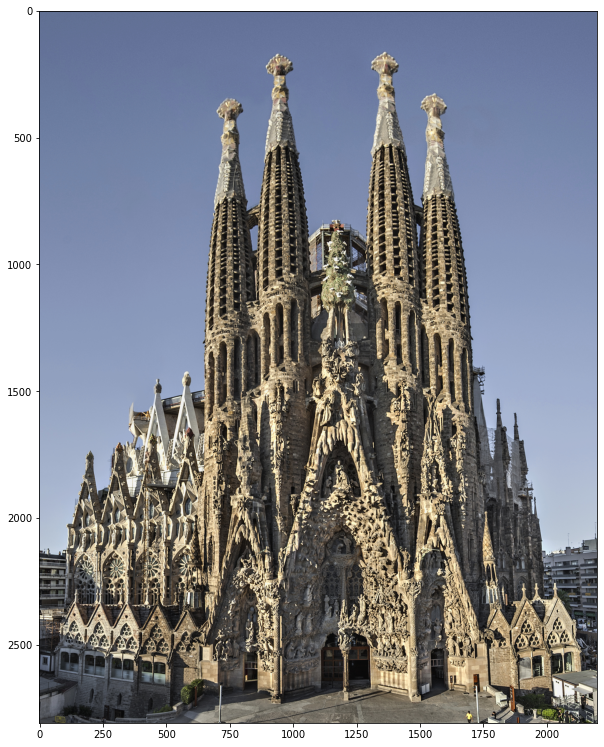

In [3]:
hr_image = cv2.imread(image_path)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(10,20))
plt.imshow(hr_image)

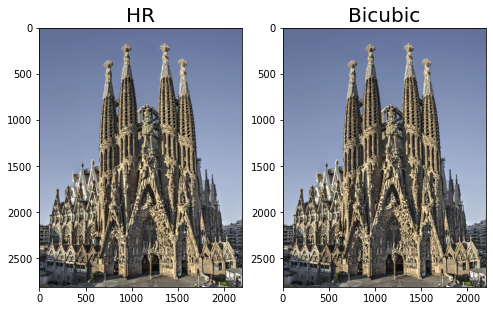

In [50]:
lr_image = cv2.resize(hr_image, dsize=(550, 702))
bicubic_image = cv2.resize(lr_image, dsize=(hr_image.shape[1], hr_image.shape[0]), interpolation=cv2.INTER_CUBIC)

images = [hr_image, bicubic_image]
titles = ['HR', 'Bicubic']

plt.figure(figsize=(8, 16))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

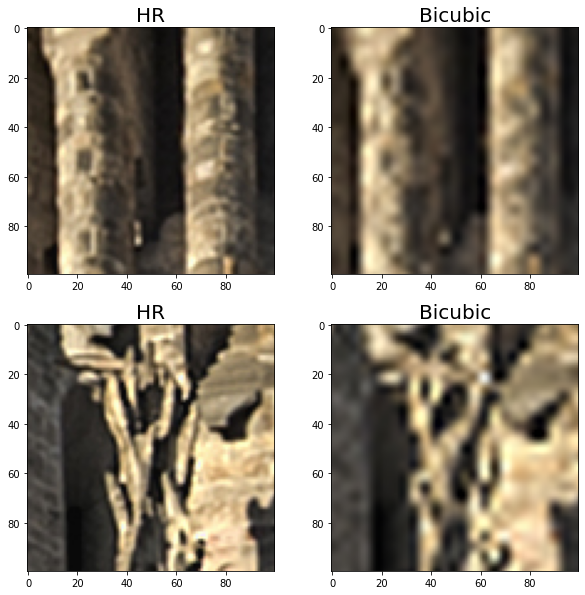

In [52]:
# 특정 부분을 잘라내서 차이를 더 잘 살펴볼 수 있도록 하자
def crop(image, left_top, x=100, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 잘라낼 영역의 좌표 정의
left_tops = [(1200, 900)]*2 + [(1500, 1500)]*2

plt.figure(figsize=(10, 10))
for i, (image, left_top, title) in enumerate(zip(images*2, left_tops, titles*2)):
    plt.subplot(2, 2,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

### SRGAN 적용

In [6]:
model_file = 'drive/My Drive/Colab Notebooks/E16_super_resolution/srgan_G.h5'
# model_file = os.getenv('HOME')+'/aiffel/aiffel_projects/exploration/E16_super_resolution/srgan_G.h5'

srgan = tf.keras.models.load_model(model_file)

In [53]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(lr_image)

/usr/local/lib/python3.7/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


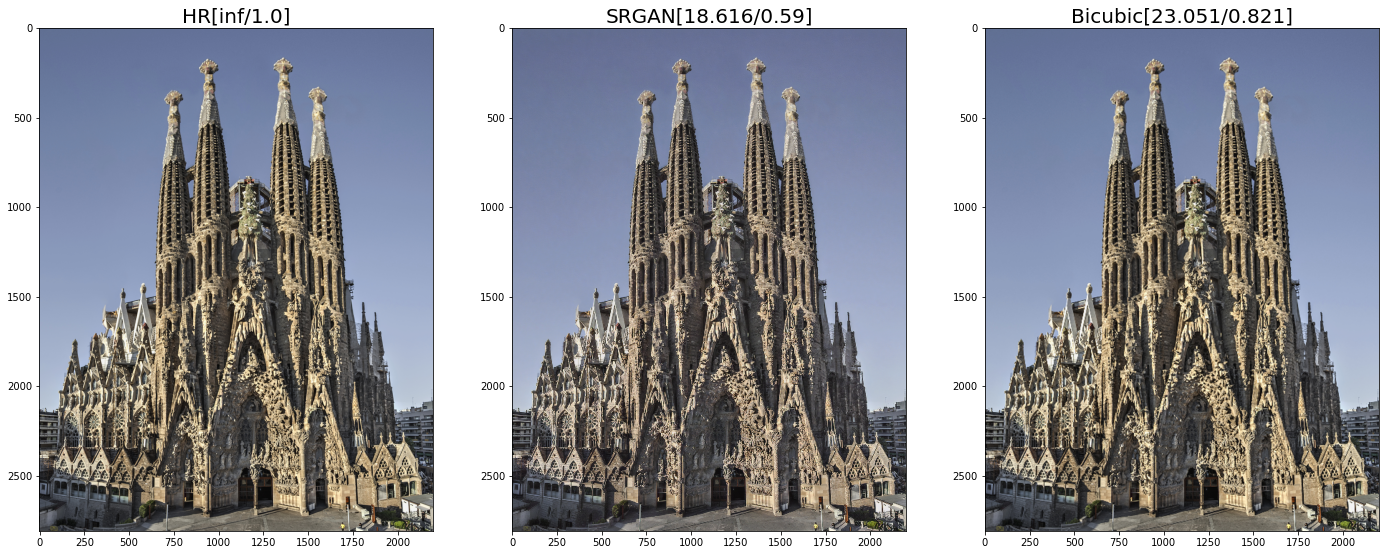

In [58]:
# 시각화
images = [hr_image, srgan_hr, bicubic_image]
titles = ['HR', 'SRGAN', 'Bicubic']

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(hr_image, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(hr_image, i, multichannel=True), 3) for i in images]

plt.figure(figsize=(24, 16))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title(title + f"[{psnr[i]}/{ssim[i]}]", fontsize=20)

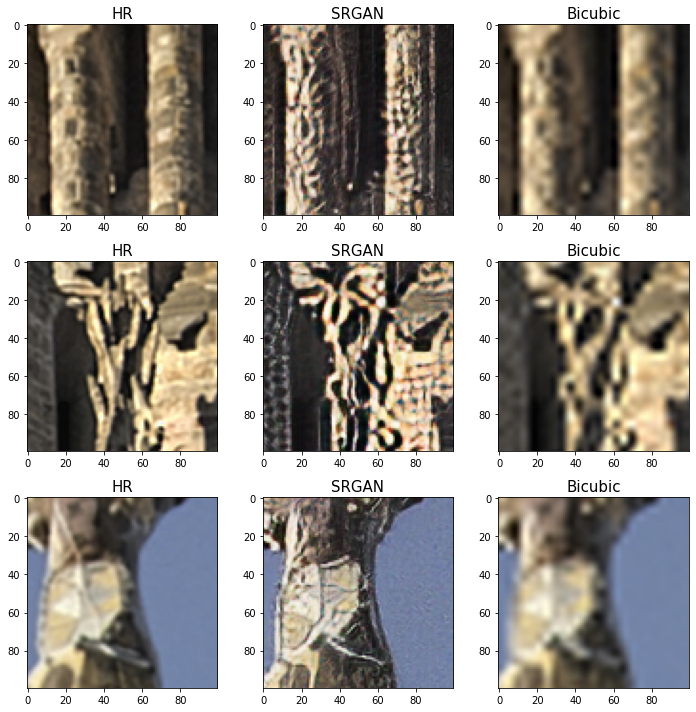

In [56]:
# 특정 부분을 잘라내서 차이를 더 잘 살펴볼 수 있도록 하자
def crop(image, left_top, x=100, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 잘라낼 영역의 좌표 정의
left_tops = [(1200, 900)]*3 + [(1500, 1500)]*3 + [(400, 720)]*3

plt.figure(figsize=(10, 10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3, 3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=15)

plt.tight_layout()

- Bicubic은 여전히 흐림
- SRGAN은 조금 선명하나 이상한 이미지가 생성됨

## 프로젝트 1-2

(479, 399, 3)


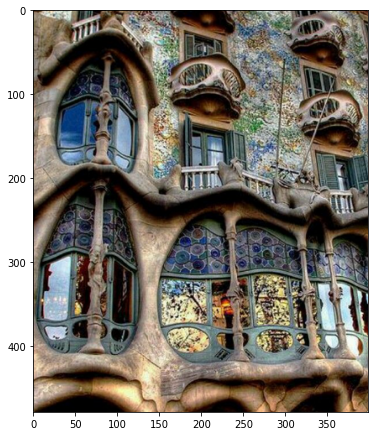

In [23]:
image_path = 'drive/My Drive/Colab Notebooks/E16_super_resolution/gaudian.PNG'

low_image = cv2.imread(image_path)
low_image = cv2.cvtColor(low_image, cv2.COLOR_BGR2RGB)

print(low_image.shape)

plt.figure(figsize=(6,12))
plt.imshow(low_image)

In [24]:
srgan_hr = apply_srgan(low_image)

In [25]:
bicubic_hr = cv2.resize(low_image, dsize=(low_image.shape[1]*4, low_image.shape[0]*4), interpolation=cv2.INTER_CUBIC)

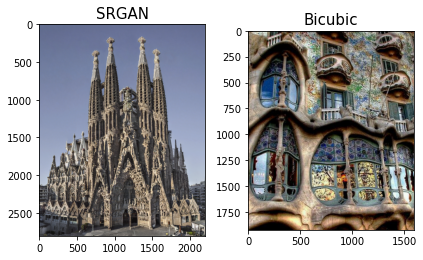

In [60]:
images = [srgan_hr, bicubic_hr]
titles = ['SRGAN', 'Bicubic']

plt.figure(figsize=(6, 12))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=15)

plt.tight_layout()

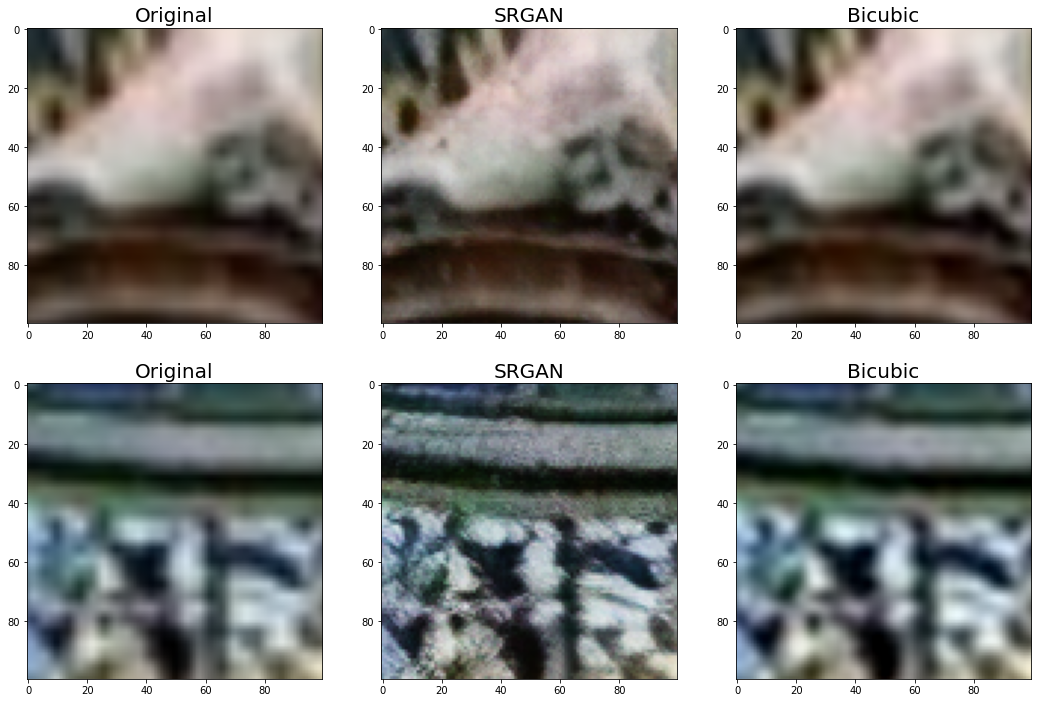

In [29]:
bigger_image = cv2.resize(low_image, dsize=(low_image.shape[1]*4, low_image.shape[0]*4))
left_tops = [(300,800), (1250,700)]

images = []
for left_top in left_tops:
    img1 = crop(bigger_image, left_top)
    img2 = crop(srgan_hr , left_top)
    img3 = crop(bicubic_hr, left_top)
    
    images.extend([img1, img2, img3])

labels = ["Original", "SRGAN", "Bicubic"] * 2

plt.figure(figsize=(18,12))
for i in range(6):
    plt.subplot(2,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=20)

- SRGAN이 가장 선명하고, 원본에 매우 가까운 이미지가 생성됨
- Bicubic은 원본보다도 흐린 것 같음

## 프로젝트 2: SRGAN을 이용해 고해상도 gif 생성하기

- [gif 파일(Given) 모음](https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e)

In [37]:
import imageio
from IPython.display import Image as show_gif

In [32]:
gif_path = 'drive/My Drive/Colab Notebooks/E16_super_resolution/wine_lr.gif'
gif = cv2.VideoCapture(gif_path)

isTrue = True
frames = []
while isTrue:
  isTrue, frame = gif.read()
  if isTrue:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 13
frame 크기 : (340, 355, 3)


### 프레임별 Super Resolution 진행하기

In [33]:
bicubic_frames_sr = []
for f in frames:
  f_sr = cv2.resize(f, dsize=(f.shape[1]*4, f.shape[0]*4), interpolation=cv2.INTER_CUBIC)
  bicubic_frames_sr.append(f_sr)

In [34]:
srgan_frames_sr = []
for f in frames:
  f_sr = apply_srgan(f)
  srgan_frames_sr.append(f_sr)

In [42]:
base_path = 'drive/My Drive/Colab Notebooks/E16_super_resolution'

In [45]:
imageio.mimsave(os.path.join(base_path, 'wine_bicubic.gif'), bicubic_frames_sr)

In [46]:
imageio.mimsave(os.path.join(base_path, 'wine_srgan.gif'), srgan_frames_sr)

In [41]:
# show_gif('wine_bicubic.gif', width=800)
# show_gif('wine_srgan.gif', width=800)

### Try Another

In [47]:
gif = cv2.VideoCapture(os.path.join(base_path, 'city_night_lr.gif'))

isTrue = True
frames = []
while isTrue:
  isTrue, frame = gif.read()
  if isTrue:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

bicubic_frames_sr = []
for f in frames:
  f_sr = cv2.resize(f, dsize=(f.shape[1]*4, f.shape[0]*4), interpolation=cv2.INTER_CUBIC)
  bicubic_frames_sr.append(f_sr)

srgan_frames_sr = []
for f in frames:
  f_sr = apply_srgan(f)
  srgan_frames_sr.append(f_sr)

imageio.mimsave(os.path.join(base_path, 'city_bicubic.gif'), bicubic_frames_sr)
imageio.mimsave(os.path.join(base_path, 'city_srgan.gif'), srgan_frames_sr)

## Results

**GIF Gengerated [LINK](https://drive.google.com/drive/folders/1N5s7YaesKGFsJtlfU5byyAX7-lsMnbrZ?usp=sharing)**